In [95]:
using QuantumOptics
using NBInclude
using Einsum
using LinearAlgebra
using Arpack
using LaTeXStrings

In [164]:
@nbinclude("Lattice_Basis_Neighbors_Hops.ipynb"; regex=r"#.*executeme")
@nbinclude("QOJulia_utils.ipynb")
@nbinclude("../My Numerical Calculations/Many-Body/Aharonov-Bohm Phase.ipynb")
@nbinclude("../My Numerical Calculations/Many-Body/Braiding Utils.ipynb");

In [3]:
param_dict=Dict{}()

LL = [8,10]
N = LL[1]*LL[2]
vv_lattice = [ [1., 0], [0, 1.] ]
b1 = [0, 0]
vv_basis = [b1]
param_dict["N"] = LL[1]*LL[2]

param_dict["LL"] = LL
param_dict["vv_lattice"] = vv_lattice
param_dict["vv_basis"] = vv_basis

nb=1 # number of basis
t=-1 # hopping amplitude
p=1
q=LL[2]
ϕ=p/q # magnetic flux per plaquet
param_dict["gauge"] = "Landau"
param_dict["t"]=t
param_dict["ϕ"]=ϕ
θθ = [0, 0] # initial values for twist angles
param_dict["θθ"]=θθ

sites, site_coord, site_number = get_sites(LL, vv_lattice, vv_basis);
param_dict["sites"] = sites
param_dict["site_coord"] = site_coord
param_dict["site_number"] = site_number

pbc=true # periodic boundary condition
param_dict["pbc"] = pbc
neighbors = [ [1, 0, 1], [-1, 0, 1], [0, 1, 1], [0, -1, 1]  ]
neighbors_list = [ neighbors ]
param_dict["neighbors_list"] = neighbors_list;

# Particle Pinning

\begin{align}
& H_{pin} =  V_0 \hat{O}, \quad V_0<0 \\
& \text{where $\hat{O}$ is pinning Operator.} 
\end{align}

In [3]:
function Vpin(site, V0, site_number, LL)
        i_site = site_number[site]
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        VV[i_site, i_site] = -V0
        return VV
end

Vpin (generic function with 1 method)

In [4]:
function Vimp(sites,VV0,site_number,LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for (site, V0) in zip(sites,VV0) 
        VM += Vpin(site, V0, site_number, LL)
    end
    return VM
end

Vimp (generic function with 1 method)

In [5]:
mutable struct impurity
    V0::Float64
    pos::Array{Float64}
    wid::Float64
end

In [8]:
function Vpin2(imp, sites, site_number, site_coord, LL)
        dimH = LL[1]*LL[2]
        VV   = zeros(dimH,dimH)
        for site in sites
            i_site = site_number[site]
            VV[i_site, i_site] = imp.V0*(tanh( norm( site_coord[site] - imp.pos )/imp.wid )^2-1)
        end
        return VV
end

Vpin2 (generic function with 1 method)

In [9]:
function Vimp2(imps, sites, site_number, site_coord, LL)
    dimH = LL[1]*LL[2]
    VM   = zeros(dimH,dimH)
    for imp in imps 
        VM +=  Vpin2(imp, sites, site_number, site_coord, LL)
    end
    return VM
end

Vimp2 (generic function with 1 method)

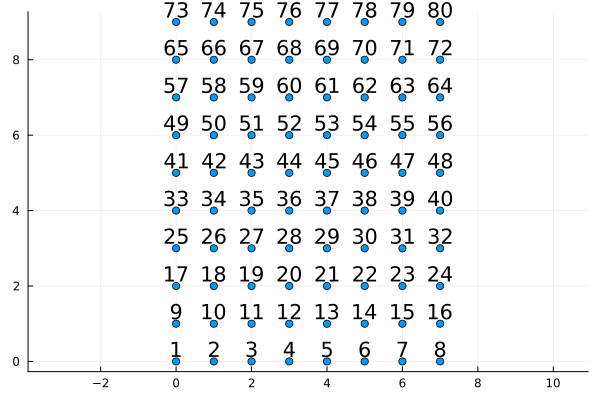

In [10]:
plot_points(sites, site_coord, site_number)

In [25]:
V0 = 10
w = 1.5
imp1 = impurity(V0, [4, 4], w)
VimpM = Vpin2(imp1, sites, site_number, site_coord, LL);

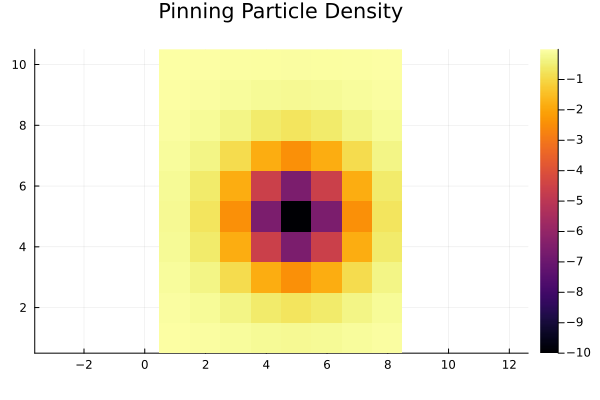

In [27]:
heatmap(reshape(diag(VimpM),LL[1],LL[2])', aspect_ratio=1, title="Pinning Particle Density")

In [34]:
imp1 = impurity(5, [5,5], .5)
imp2 = impurity(5, [1,3], .5)
imps = [imp1, imp2]

2-element Vector{impurity}:
 impurity(5.0, [5.0, 5.0], 0.5)
 impurity(5.0, [1.0, 3.0], 0.5)

In [35]:
VimpM = Vimp2(imps, sites, site_number, site_coord, LL);

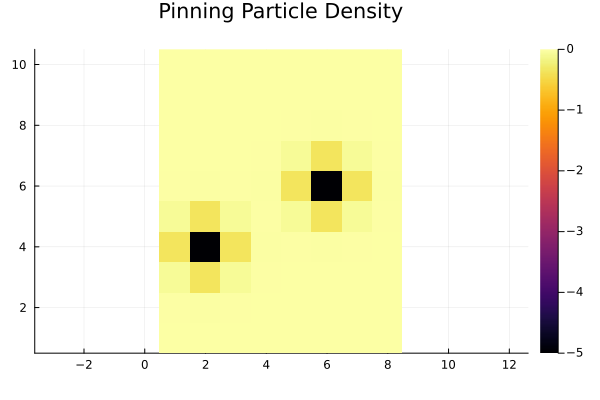

In [37]:
heatmap(reshape(diag(VimpM),LL[1],LL[2])', aspect_ratio=1, title="Pinning Particle Density")

# Magnetic Field is Opened

In [38]:
basis = NLevelBasis(N) 
param_dict["basis"] = basis;

param_dict["model_H1"] = get_Hofstadter_hamiltonian

H_T = get_Hofstadter_hamiltonian(param_dict)
H_Kin = get_sp_op(basis, H_T)
Vimp_op = get_sp_op(basis, VimpM);

In [48]:
function Himp(imps, H_Kin)
    VimpM = Vimp2(imps, sites, site_number, site_coord, LL);
    Vimp_op = get_sp_op(basis, VimpM)
    return H_Kin + Vimp_op
end

Himp (generic function with 1 method)

In [49]:
E_Kin, U_Kin = eigen(dense(H_Kin).data);

In [50]:
imps = [ impurity(2, [2,7], .5), 
         impurity(2.0001, [5,2], .5)];

In [51]:
H1 = Himp(imps, H_Kin)
EE, UU = eigen(dense(H1).data)
EE, UUS = eigenstates(dense(H1));

In [52]:
imps = [ impurity(1, [2,7], .5) ];

In [53]:
H1 = Himp(imps, H_Kin)
EE2, UU2 = eigen(dense(H1).data)
EE2, UUS2 = eigenstates(dense(H1));

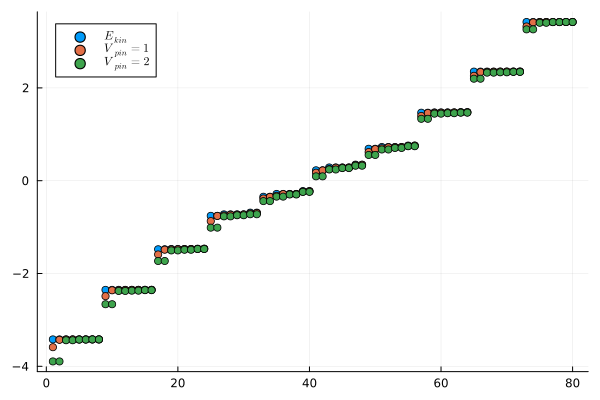

In [62]:
scatter(E_Kin, label=L"$E_{kin}$")
scatter!(EE2, label=L"$V_{pin} = 1$")
scatter!(EE, label=L"$V_{pin} = 2$")

# Aharonov Bohm Phase

### Full Hilbert Space

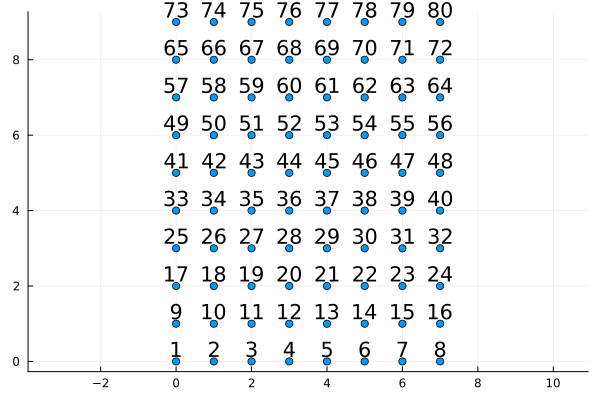

In [166]:
plot_points(sites, site_coord, site_number)

In [167]:
x0, y0 = site_coord[ sites[20] ]
x1, y1 = site_coord[ sites[22] ]
x2, y2 = site_coord[ sites[54] ]
x3, y3 = site_coord[ sites[52] ]
co = [x0, y0, x1, y1, x2, y2, x3, y3];

In [168]:
wid = 1
V0 = 0.1
step = 0.1;

In [169]:
# Initial Configuration
imps = [ impurity(V0, [x0,y0], wid)]
H1 = Himp(imps, H_Kin)
E_0, U_0 = eigenstates(dense(H1));

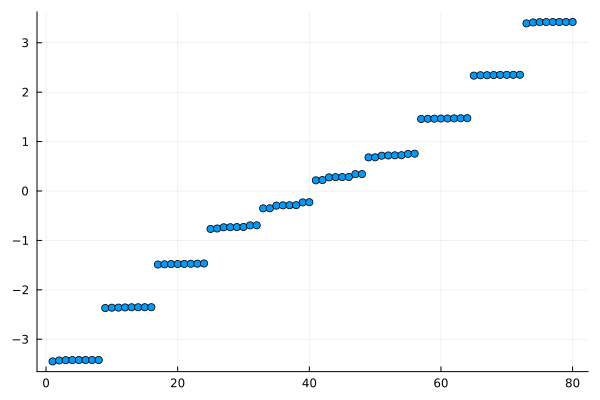

In [170]:
scatter(E_0, legend=false)

In [171]:
Degeneracy = 1; #There is no degeneracy at single particle level

In [172]:
θ, ψ_list = get_ab_phase(co, step, V0, wid, H_Kin, U_0, Degeneracy);

In [173]:
θ

-0.4022942812667626

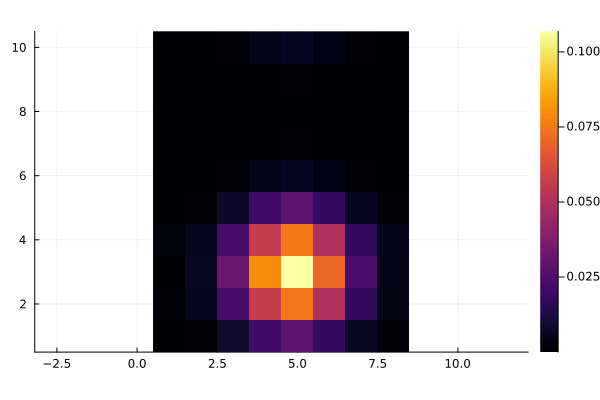

In [174]:
heatmap(reshape(real( diag( dm(ψ_list[10][1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

### Sub Space

In [175]:
cut_off = 8;

In [180]:
PN = 1; U = 0;

In [181]:
P1M, P1_dagM, P2M, P2_dagM, basis_tilde, basis_tilde2, basis_mb_tilde = projection_operators(cut_off, basis, U_0, PN);

In [182]:
H1_proj = Himp_proj2(imps, H_Kin, P1M, P1_dagM, P2M, P2_dagM, basis_tilde, basis_mb_tilde, Int_Operator, basis_tilde2);

In [183]:
E_0M, U_0M  = eigenstates(dense(H1_proj));

In [184]:
V2 = SparseOperator(basis⊗basis)
for m in 1:N
    V2 += U/2 * transition(basis,m,m)⊗transition(basis,m,m)
end

In [185]:
Int_Operator = V2;

In [187]:
θ_proj, ψ_proj_list = get_ab_phase_projection(co, step, V0, wid, H_Kin, U_0M, Degeneracy, P1M, P1_dagM, P2M, P2_dagM, basis_tilde, basis_mb_tilde, Int_Operator, basis_tilde2);

In [188]:
θ_proj

-0.3914124389542688

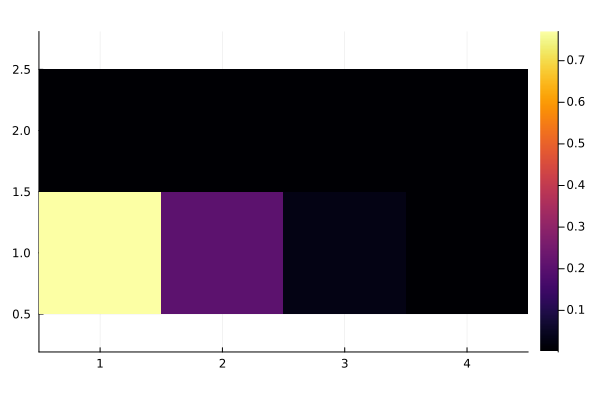

In [190]:
heatmap(reshape(real( diag( dm(ψ_proj_list[10][1]).data ) ),4,2)', aspect_ratio=1)

### Fully Localised Particle

In [256]:
V1 = -1;

In [257]:
Imp_Site = [rec_path_1[1], rec_path_1[2], rec_path_2[1], rec_path_2[2]]
V0 = [V1, 0, 0, 0]
Impurity_Data = Impurity(V0, Imp_Site)

Impurity([-1.0, 0.0, 0.0, 0.0], [20, 21, 20, 21])

In [262]:
function Vpin_site_loc(Impurity_Data, LL)
    dimH = LL[1]*LL[2]
    VV   = zeros(dimH,dimH)
    VV[Impurity_Data.Imp_Site, Impurity_Data.Imp_Site] = -V1
    return VV
end

Vpin_site_loc (generic function with 2 methods)

In [263]:
function Himp(imps, H_Kin)
    VimpM = Vpin_site_loc(LL, site_idx)
    Vimp_op = get_sp_op(basis, VimpM)
    return H_Kin + Vimp_op
end

Himp (generic function with 1 method)

In [252]:
lens = [2, 4, 2, 4]
dirs = [1,LL[1], -1, -LL[1]]
rec_path_1 = push!(unique(rectangular_path(20,lens,dirs)),20)
rec_path_2 = push!(unique(rectangular_path(20,lens,dirs)),20)

13-element Vector{Int64}:
 20
 21
 22
 30
 38
 46
 54
 53
 52
 44
 36
 28
 20

In [124]:
EE[1:3]

3-element Vector{Float64}:
 -3.448900402101327
 -3.429219949700187
 -3.423405935223483

In [125]:
function calc_pr(state)
    return sum( ( real( diag( dm(state).data ) ) ).^2 )
end

calc_pr (generic function with 1 method)

In [126]:
prs=[]
prs2=[]
for i in 1:prod(LL)
    pr = calc_pr(UUS[i])
    push!(prs,pr)
    pr = calc_pr(UUS2[i])
    push!(prs2,pr)
end

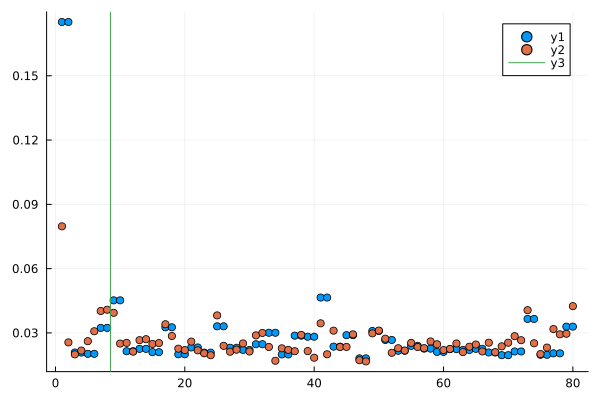

In [127]:
scatter(prs)
scatter!(prs2)
vline!([8.5])

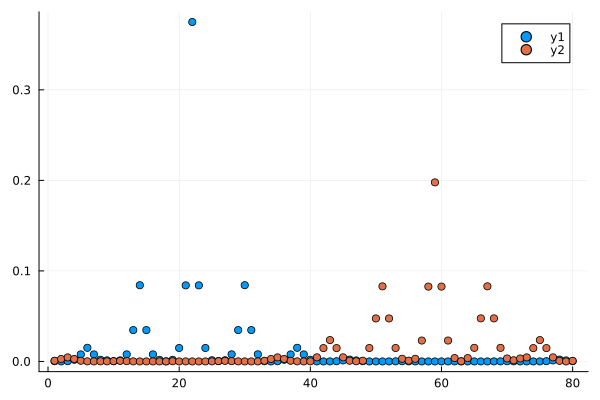

In [128]:
scatter(  real( diag( dm(UUS[1]).data ) ) )
scatter!(  real( diag( dm(UUS2[1]).data ) ) )

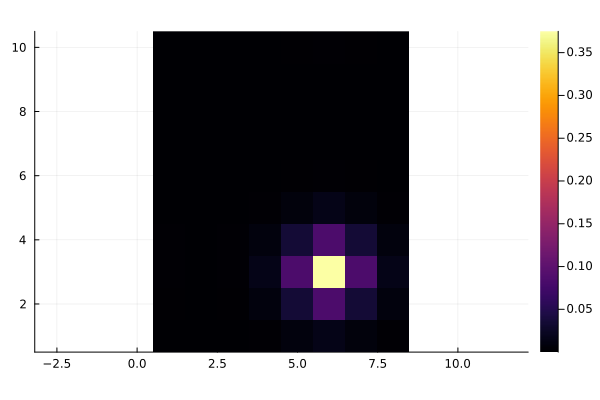

In [129]:
heatmap(reshape(real( diag( dm(UUS[1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

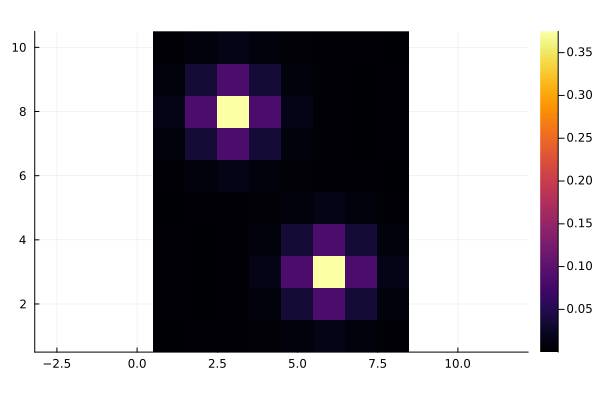

In [130]:
heatmap(reshape(real( diag( dm(UUS[1]).data+dm(UUS[2]).data ) ),LL[1],LL[2])', aspect_ratio=1)

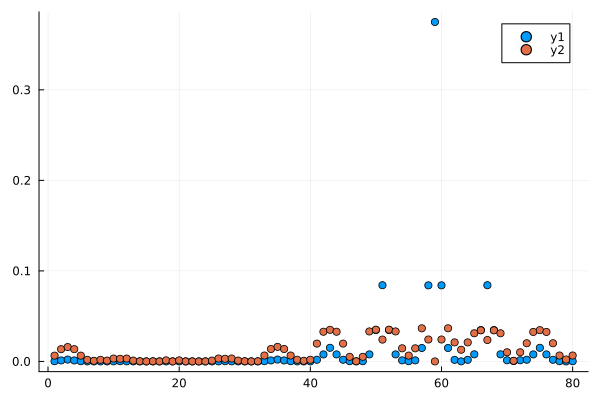

In [131]:
scatter(  real( diag( dm(UUS[2]).data ) ) )
scatter!(  real( diag( dm(UUS2[2]).data ) ) )

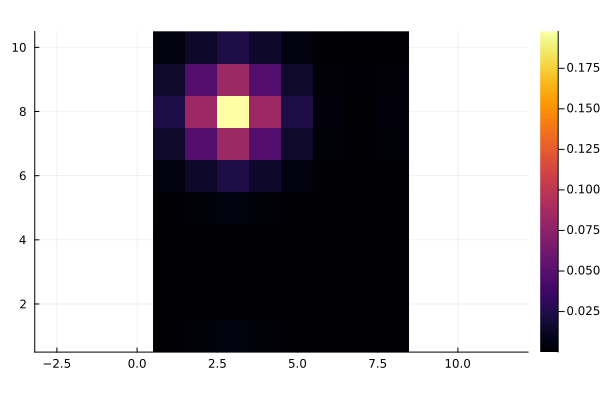

In [132]:
heatmap(reshape(real( diag( dm(UUS2[1]).data ) ),LL[1],LL[2])', aspect_ratio=1)

# Path

In [133]:
function circular_path(θ,center,radius)
    return [center[1]+radius*cos(θ), center[2]+radius*sin(θ)]
end

circular_path (generic function with 1 method)

11-element Vector{Float64}:
 1.0
 1.1
 1.2
 1.3
 1.4
 1.5
 1.6
 1.7
 1.8
 1.9
 2.0

[ Info: Saved animation to /home/can/Kagome-Lattice/Julia/tmp.gif


Plots.AnimatedGif("/home/can/Kagome-Lattice/Julia/tmp.gif")
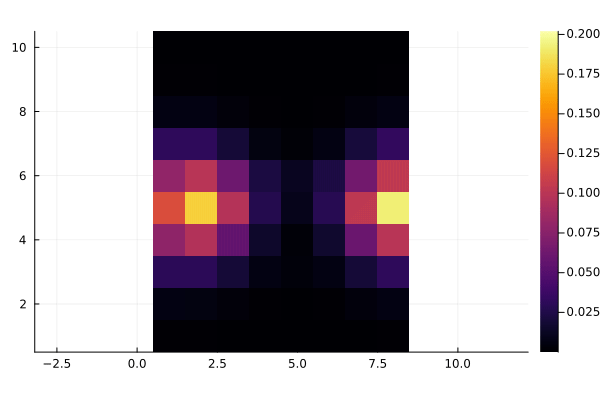

In [172]:
@gif for i in 1:1/50:2
    center = [4,4]
    radius = 3 
    θ = i * pi
    
    imp_pos = circular_path(θ,center,radius)
    imp_pos2 = circular_path(θ+pi,center,radius)
    
    V0 = 1
    w0 = 1
    
    imps = [ impurity(1.1*V0, imp_pos2, w0), 
             impurity(V0, imp_pos, w0) ]
    
    H1 = Himp(imps, H_Kin)
    EE, UU = eigen(dense(H1).data)
    EE, UUS = eigenstates(dense(H1))
    
    heatmap!(reshape(real( diag( dm(UUS[1]).data + dm(UUS[2]).data ) ),LL[1],LL[2])', aspect_ratio=1)
    
end

# Braiding

In [47]:
U = 2
V2 = SparseOperator(basis⊗basis)
for m in 1:N
    V2 += U/2 * transition(basis,m,m)⊗transition(basis,m,m)
end

In [50]:
substates = 1:8
PN = 3
basis_tilde = SubspaceBasis(basis, UUS[substates])
basis_tilde2 = basis_tilde⊗basis_tilde
states_mb_tilde = bosonstates(basis_tilde, PN)
basis_mb_tilde  = ManyBodyBasis(basis_tilde, states_mb_tilde)

ManyBody(onebodybasis=Subspace(superbasis=NLevel(N=80), states:8), states:120)

In [51]:
P1 = projector(basis, basis_tilde)
P1_dag = dagger(P1)
P1M = P1.data
P1_dagM = P1_dag.data
P2M = (P1⊗P1).data
P2_dagM = (P1_dag⊗P1_dag).data;
H1M = H1.data;
V2M = V2.data;

In [52]:
H1_tildeM = P1_dagM * H1M * P1M
V2_tildeM =  P2_dagM * V2M * P2M;

LoadError: DimensionMismatch: A has dimensions (8,80) but B has dimensions (8,8)

In [143]:
H1_tilde = Operator(basis_tilde, H1_tildeM);

V2_tilde = Operator(basis_tilde2, V2_tildeM);

H_NI_tilde_mb = manybodyoperator(basis_mb_tilde, H1_tilde);

Vint_tilde_mb = manybodyoperator(basis_mb_tilde, V2_tilde);

H_tilde_mb = H_NI_tilde_mb + Vint_tilde_mb;

H_tilde_mb = (H_tilde_mb + H_tilde_mb')/2;

In [144]:
E_tilde_mb, U_tilde_mb = eigenstates(H_tilde_mb);
E_tilde_mb

10-element Vector{Float64}:
 -11.174932000842754
 -11.139158642818922
 -10.972550719551142
 -10.869788849792853
 -10.848568803058487
 -10.763097050029108
 -10.755716261365095
 -10.747479736979944
 -10.6193785758803
 -10.459843837229005

In [ ]:
# BRADİNG HESAPLANCAK!